In [ ]:
from google.colab import output
!gdown 1TC5lvMLoXMc4waX-BQCoUFe8l8JMdcev
!unzip boards2.zip
output.clear()

In [ ]:
import os
import gc
import yaml
import tqdm
import cv2
import torch
import skimage
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms, utils
from torchvision.models import resnet18, ResNet18_Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def read_annot(path):
    with open(path) as f:
        annot = f.read()
    return annot


def load_board_extractor_state(path):
    with open(path) as f:
        board_annotation = yaml.load(f, Loader=yaml.FullLoader)

    return board_annotation

In [ ]:
board_size = 19
y_grid = np.linspace(0, warped.shape[0], board_size)
x_grid = np.linspace(0, warped.shape[1], board_size)
grid = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1, 2)

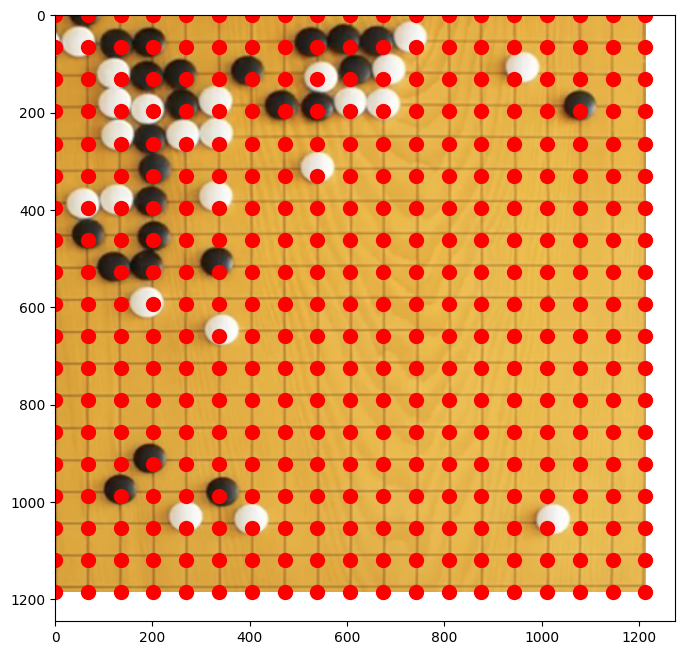

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(warped)
plt.scatter([pt[0] for pt in grid], [pt[1] for pt in grid], c='red', s=100)
plt.show()

In [ ]:
state_converter = {'.': 0, 'W': 1, 'B': 2}

def warped_board_cell_splitter(warped, state, board_size=19):
    cells = []
    cells_state= []
    cell_size = warped.shape[0] / (4 * board_size), warped.shape[1] / (4 * board_size)
    y_grid = np.linspace(0, warped.shape[0], board_size)
    x_grid = np.linspace(0, warped.shape[1], board_size)
    for x in range(board_size):
        for y in range(board_size):
            y_min, y_max = np.clip([int(y_grid[y] - cell_size[0]), int(y_grid[y] + cell_size[0])], 0, warped.shape[0]).tolist()
            x_min, x_max = np.clip([int(x_grid[x] - cell_size[1]), int(x_grid[x] + cell_size[1])], 0, warped.shape[1]).tolist()
            cell = warped[y_min : y_max, x_min : x_max]
            cur_state = state_converter[state[y * (board_size * 2) + (x * 2)]]
            cells.append(cell)
            cells_state.append(cur_state)
    return cells, cells_state

def get_cells_data(path):
    dataset = []
    for dirname, _, filenames in tqdm.tqdm(os.walk(path)):
        for filename in filenames:
            if filename.endswith('.jpg') or filename.endswith('.JPG') or filename.endswith('.png'):
                if os.path.exists(os.path.join(dirname, 'board_extractor_state.yml')):
                    board_info = load_board_extractor_state(os.path.join(dirname, 'board_extractor_state.yml'))
                else:
                    continue
                image = cv2.imread(os.path.join(dirname, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                corners = np.array(board_info['pts_clicks'], dtype='float32')
                warped = four_point_transform(image, corners)

                if os.path.exists(os.path.join(dirname, filename[:-4] + '.txt')):
                    annotation = read_annot(os.path.join(dirname, filename[:-4] + '.txt'))

                if os.path.exists(os.path.join(dirname, filename[:-4] + '.TXT')):
                    annotation = read_annot(os.path.join(dirname, filename[:-4] + '.TXT'))

                cells, cells_state = warped_board_cell_splitter(warped, annotation)
                for cell, state in zip(cells, cells_state):
                    dataset.append({'cell': cell, 'cell_state': state})
    return dataset

def visualize_datapoint(cell_datapoint):
    plt.imshow(cell_datapoint['cell'])
    plt.title(cell_datapoint['cell_state'])
    plt.show()


cell_train_data = get_cells_data('./dataset/')
cell_test_data = get_cells_data('./dataset2/')

41it [02:13,  3.27s/it]
23it [02:16,  5.95s/it]


In [ ]:
from torchvision.transforms import v2
cell_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class GoCellsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

class CellTransformation(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, state = sample['cell'], sample['cell_state']
        image = cell_transforms(image)
        return {'cell': image,
                'cell_state': torch.tensor(state)}

In [ ]:
black_train_idx = []
white_train_idx = []
none_train_idx = []
for i in np.random.permutation(len(cell_train_data)).tolist():
    if cell_train_data[i]['cell_state'] == 0:
        none_train_idx.append(i)
    elif cell_train_data[i]['cell_state'] == 1:
        white_train_idx.append(i)
    elif cell_train_data[i]['cell_state'] == 2:
        black_train_idx.append(i)

min_train_size = min(len(none_train_idx), len(white_train_idx), len(black_train_idx))
train_idx = black_train_idx[:min_train_size] + white_train_idx[:min_train_size] + none_train_idx[:min_train_size]

black_test_idx = []
white_test_idx = []
none_test_idx = []
for i in np.random.permutation(len(cell_test_data)).tolist():
    if cell_test_data[i]['cell_state'] == 0:
        none_test_idx.append(i)
    elif cell_test_data[i]['cell_state'] == 1:
        white_test_idx.append(i)
    elif cell_test_data[i]['cell_state'] == 2:
        black_test_idx.append(i)

min_test_size = min(len(none_test_idx), len(white_test_idx), len(black_test_idx))
test_idx = black_test_idx[:min_test_size] + white_test_idx[:min_test_size] + none_test_idx[:min_test_size]

In [ ]:
BATCH_SIZE = 512
train_dataset = GoCellsDataset([cell_train_data[id] for id in train_idx], CellTransformation())
test_dataset = GoCellsDataset([cell_test_data[id] for id in test_idx], CellTransformation())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
preprocess = weights.transforms()

for name, param in model.layer1.named_parameters():
    param.requires_grad = False

for name, param in model.layer2.named_parameters():
    param.requires_grad = False

for name, param in model.layer3.named_parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(in_features=512, out_features=len(state_converter), bias=True)
model = model.to(device)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, max_step):
    size = len(dataloader.dataset)
    model.train()
    for num_batch, batch in enumerate(tqdm.notebook.tqdm(dataloader)):
        X, y = batch['cell'], batch['cell_state']
        pred = model(preprocess(X).to(device))
        loss = loss_fn(pred, y.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), (num_batch + 1) * len(X)
        if num_batch > max_step:
                break
        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, max_step):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    overall = 0
    steps = 0
    with torch.no_grad():
        for num_batch, batch in enumerate(tqdm.notebook.tqdm(dataloader)):
            X, y = batch['cell'], batch['cell_state']
            X = preprocess(X).to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            overall += len(y)
            steps += 1
            if num_batch > max_step:
                break

    test_loss /= steps
    correct /= overall
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
learning_rate = 3e-4
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, 200)
    test_loop(test_dataloader, model, loss_fn, 20)
test_loop(test_dataloader, model, loss_fn, 200)
print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.324681 

Epoch 2
-------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.273971 

Epoch 3
-------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.250092 

Epoch 4
-------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
medians = []
verdicts = []

gray_transform = v2.Grayscale()
for i in tqdm.notebook.tqdm(range(len(train_dataset))):
    median = gray_transform(train_dataset[i]['cell']).median()
    medians.append(median)
    verdicts.append(train_dataset[i]['cell_state'])

  0%|          | 0/97728 [00:00<?, ?it/s]

In [ ]:
import statsmodels.api as sm
y = verdicts[min_train_size:]
x = medians[min_train_size:]
X = np.array([[1 for _ in range(len(x))], x])
result = sm.GLM(y, X.T, family=sm.families.Binomial() ).fit()
result.summary()
print(-result.params[0]/result.params[1])

1.165713116948212


In [ ]:
y = np.clip(verdicts[:min_train_size] + verdicts[2 * min_train_size:], 0, 1)
print(y)
x = medians[:min_train_size] + medians[2 * min_train_size:]
X = np.array([[1 for _ in range(len(x))], x])
result = sm.GLM(y, X.T, family=sm.families.Binomial() ).fit()
result.summary()
print(-result.params[0]/result.params[1])

[1 1 1 ... 0 0 0]
-0.8508538316506075


In [ ]:
THR1 = -0.8508538316506075
THR2 = 1.165713116948212

medians_val = []
verdicts_val_true = []
verdicts_val_pred = []

for i in tqdm.notebook.tqdm(range(len(test_dataset))):
    median = gray_transform(test_dataset[i]['cell']).median()
    medians_val.append(median)
    verdicts_val_true.append(test_dataset[i]['cell_state'])
    if median < THR1:
        verdicts_val_pred.append(2)
    elif median < THR2:
        verdicts_val_pred.append(0)
    else:
        verdicts_val_pred.append(1)

  0%|          | 0/204438 [00:00<?, ?it/s]

In [ ]:
np.mean(np.array(verdicts_val_true) == np.array(verdicts_val_pred))

0.9290151537385417

In [ ]:
verdicts_val_true = np.array(verdicts_val_true)
verdicts_val_pred = np.array(verdicts_val_pred)

In [ ]:
verdicts_val_pred_resnet = []
model.eval()
with torch.no_grad():
    for num_batch, batch in enumerate(tqdm.notebook.tqdm(test_dataloader)):
        X, y = batch['cell'], batch['cell_state']
        X = preprocess(X).to(device)
        y = y.to(device)
        pred = model(X)
        verdicts_val_pred_resnet += np.array(pred.argmax(1).to('cpu')).tolist()

  0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
verdicts_val_pred_resnet = np.array(verdicts_val_pred_resnet)
print(np.mean(verdicts_val_true == verdicts_val_pred_resnet))

0.9496473258396189


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(f1_score(y_true=verdicts_val_true, y_pred=verdicts_val_pred, average='micro'))
print(f1_score(y_true=verdicts_val_true, y_pred=verdicts_val_pred, average='macro'))
print(f1_score(y_true=verdicts_val_true, y_pred=verdicts_val_pred_resnet, average='micro'))
print(f1_score(y_true=verdicts_val_true, y_pred=verdicts_val_pred_resnet, average='macro'))

0.9290151537385417
0.9292343571033453
0.9496473258396189
0.9499612109562517


In [ ]:
cm1 = confusion_matrix(y_true=verdicts_val_true, y_pred=verdicts_val_pred)

In [ ]:
cm2 = confusion_matrix(y_true=verdicts_val_true, y_pred=verdicts_val_pred_resnet)

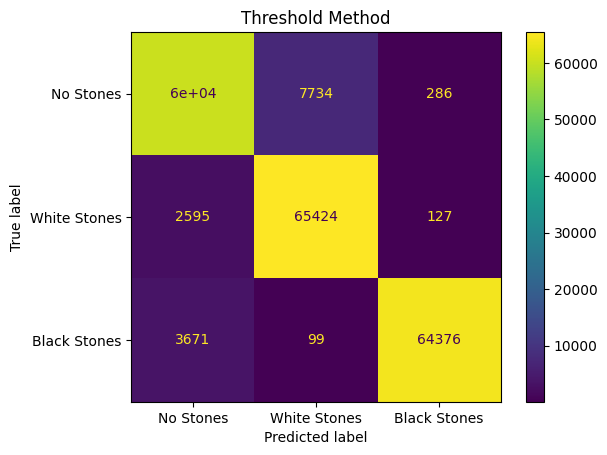

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['No Stones', 'White Stones', 'Black Stones'])
disp.plot()
plt.title('Threshold Method')
plt.show()

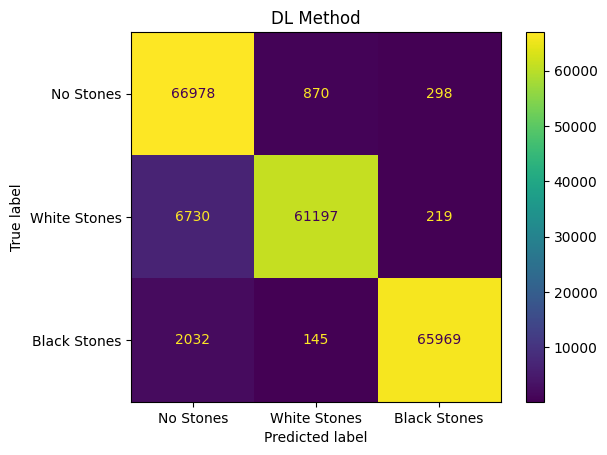

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['No Stones', 'White Stones', 'Black Stones'])
disp.plot()
plt.title('DL Method')
plt.show()

(array([2.1123e+04, 8.0100e+03, 2.4840e+03, 8.7300e+02, 6.3000e+01,
        1.4000e+01, 1.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([-2.03371239, -1.71017981, -1.38664722, -1.06311464, -0.73958206,
        -0.41604948, -0.0925169 ,  0.23101568,  0.55454826,  0.87808084,
         1.20161343]),
 <BarContainer object of 10 artists>)

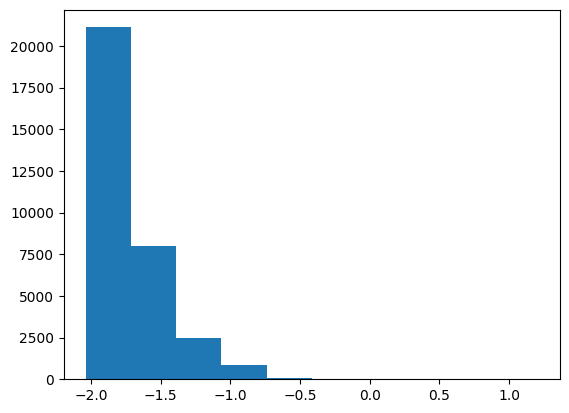

In [ ]:
plt.hist(medians[:min_train_size])

(array([   20.,   230.,  1176.,  3216.,  6916., 13810.,  7688.,  6075.,
         9447., 16574.]),
 array([-1.73259747, -1.31946468, -0.9063319 , -0.49319914, -0.08006637,
         0.3330664 ,  0.74619919,  1.15933192,  1.5724647 ,  1.98559749,
         2.39873028]),
 <BarContainer object of 10 artists>)

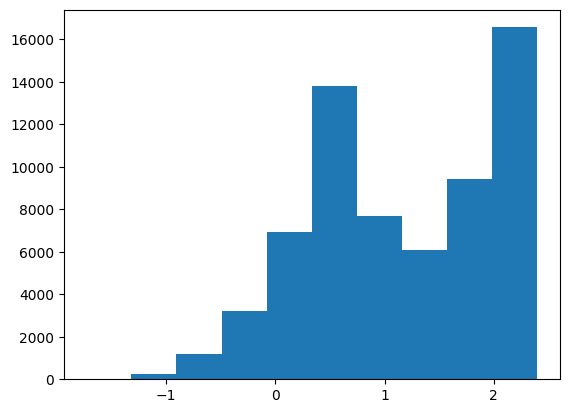

In [ ]:
plt.hist(medians[min_train_size:])

In [ ]:
test_loop(test_dataloader, model, loss_fn, 5)

  0%|          | 0/400 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.304143 



In [ ]:
torch.save(model, './model.pt')